<a href="https://www.kaggle.com/code/siddp6/cifar-10-cnn?scriptVersionId=138706073" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

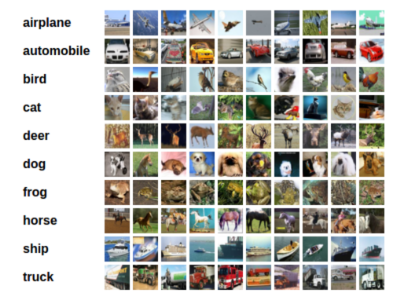

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
import torch 
import numpy as np

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')    

CUDA is available!  Training on GPU ...


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

Note that of course:

- The resize and crop should be the same as applied during training for best performance
- The normalization should be the same between training and inference (validation and test)

In [2]:
import torchvision.transforms as T
import multiprocessing

num_workers = multiprocessing.cpu_count()
batch_size = 64
valid_size = .2

train_transforms = T.Compose([
    T.transforms.ToTensor(),
    T.transforms.Normalize((.5), (.5))
])

test_transforms = T.Compose([
    T.transforms.ToTensor(),
    T.transforms.Normalize((.5), (.5))
])

In [3]:
from torchvision import datasets
root = "data"
train_val_data = datasets.CIFAR10(root=root, train=True, download=True,transform=train_transforms)
test_data = datasets.CIFAR10("data", train=False, download=True, transform=test_transforms)

val_len = int(len(train_val_data)*valid_size)
train_len = int(len(train_val_data)-val_len)

train_subset, val_subset = torch.utils.data.random_split(
    train_val_data, [train_len, val_len], generator=torch.Generator().manual_seed(42)
)

train_loader = torch.utils.data.DataLoader(
    dataset = train_subset, shuffle=True, batch_size=batch_size, num_workers=num_workers
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_subset, shuffle=False, batch_size=batch_size, num_workers=num_workers
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=batch_size, num_workers=num_workers
)

100%|██████████| 170498071/170498071 [00:05<00:00, 30565767.93it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
# specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

NOTE: 
- It is important to use BatchNorm before DropOut. 
- The latter drops some connections only at training time, so placing it before BatchNorm would cause the distribution seen by BatchNorm to be different between training and inference.

In [5]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, n_classes = 10):
        super(Net, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, 3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
            
            nn.Conv2d(32, 64, 3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),  
            
            nn.Linear(64 * 4 * 4, 500), 
            nn.Dropout(0.5),
            nn.ReLU(),
            
            nn.Linear(500, n_classes),
            
        )
    
    def forward(self, X):
        return self.model(X)

In [6]:
model = Net()
print(model)

Net(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=500, bias=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): ReLU()
    (13): Linear(in_features=500, out_features=10, bias=True)
  )
)


## How many parameters?

Now that you built the network, can you compute with pen and paper how many parameters does your network have? Does your answer match the output of the following cell?

In [7]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

541094

## Visualize your network (optional)

You can visualize your achitecture by using netron.app. Just execute the following cell (which will save the network to a file called "cifar10_network.pt" in this directory), then download the produced `cifar10_network.pt` to your computer. Finally, go to [Netron.app](https://netron.app) and click on `Open Model`, and select the file you just downloaded.

In [8]:
scripted = torch.jit.script(model)
torch.jit.save(scripted, "cifar10_network.pt")

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

In [9]:
import torch.optim as optim

criterion  = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=.01)

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting. (In fact, in the below example, we could have stopped around epoch 33 or so!)

In [10]:
!pip install livelossplot

In [11]:
from livelossplot import PlotLosses
from tqdm import tqdm
import utility

def run_model(model, epochs, train_loader, val_loader, optimizer, criterion, save_path, is_cuda=False, interactive_tracking=False):
    
    if interactive_tracking:
        liveloss = PlotLosses()
    else:
        liveloss = None
    
    val_loss_min = None
    logs = {}

    for epoch in tqdm(
            range(epochs),
            desc="Epochs",
            total=epochs,
            leave=True,
            ncols=80
        ):
        train_loss = utility.run(
            model=model, 
            optimizer=optimizer, 
            criterion=criterion,
            data_loader=train_loader, 
            is_cuda=is_cuda, 
            mode="Train"
        )
        val_loss = utility.run(
            model=model, 
            optimizer=None, 
            criterion=criterion,
            data_loader=train_loader, 
            is_cuda=is_cuda, 
            mode="Val"
        )
        print(
            "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
                epoch + 1, train_loss, val_loss
            )
        ) 
        
        if val_loss_min is None or ((val_loss_min - val_loss) / val_loss_min > 0.1):
            torch.save(model.state_dict(), save_path)
            val_loss_min = val_loss
        
        if interactive_tracking:
            logs['loss'] = train_loss
            logs['val_loss'] = val_loss
            liveloss.update(logs)
            liveloss.send()

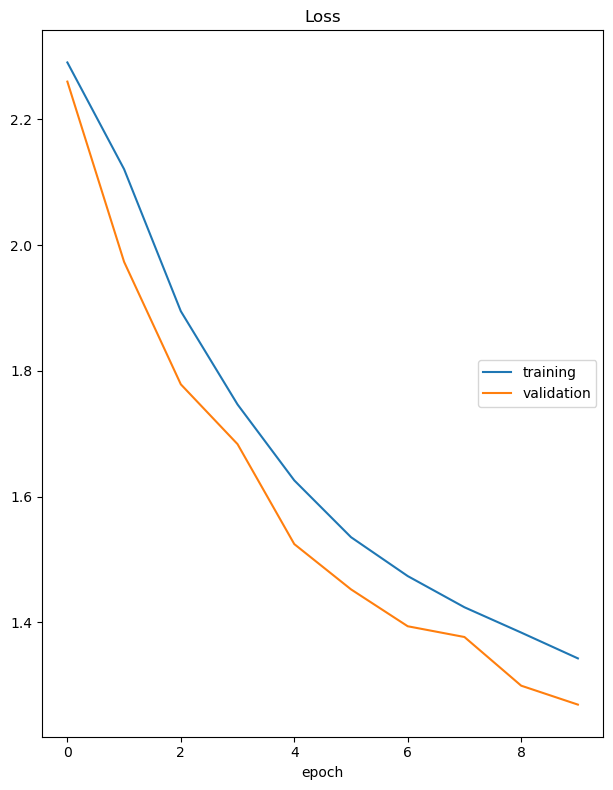

Epochs: 100%|███████████████████████████████████| 10/10 [03:48<00:00, 22.88s/it]

Loss
	training         	 (min:    1.343, max:    2.291, cur:    1.343)
	validation       	 (min:    1.269, max:    2.260, cur:    1.269)


In [12]:
run_model(model, 10, train_loader, val_loader, optimizer, criterion, save_path="cifar10_best_valid.pt", is_cuda=train_on_gpu, interactive_tracking=True)

###  Load the Model with the Lowest Validation Loss

In [13]:
model.load_state_dict(torch.load("cifar10_best_valid.pt"))

<All keys matched successfully>

In [14]:
def test_run(model, criterion, data_loader, is_cuda):
    class_correct = list(0 for i in range(10))
    class_total = list(0 for i in range(10))
    test_loss = 0
    correct = 0
    total = 0
    
    if is_cuda:
        model.cuda()
        
    with torch.no_grad():
        model.eval()
        
    preds = list()
    actuals = list()
    
    for batch_idx, (data, target) in tqdm(
            enumerate(data_loader),
            desc='Testing',
            total=len(data_loader),
            leave=True,
            ncols=80
        ):
        
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
            
        output = model(data)
        loss_value = criterion(output, target).detach()
        test_loss += loss_value*data.size(0)
        
        _, pred = torch.max(output, 1)
        pred = pred.cpu().numpy().tolist()
        preds.extend(pred)
        actuals.extend(target.cpu().numpy().tolist())

        
        for i in range(target.shape[0]):
            label = target[i]
            class_correct[label] += (1 if pred[i] == label else 0)
            class_total[label] += 1
    
    test_loss = test_loss/len(test_loader.dataset)
    
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * sum(class_correct) / sum(class_total), sum(class_correct), sum(class_total)))
    
    return test_loss, preds, actuals

In [15]:
test_loss, preds, actuals = test_run(model, criterion, test_loader, train_on_gpu)

Testing: 100%|████████████████████████████████| 157/157 [00:03<00:00, 47.22it/s]

Test Loss: 1.310993


Test Accuracy: 52% (5298/10000)


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(pred, truth, classes):
    cm = confusion_matrix(truth, pred)
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", linewidths=0.5, linecolor='lightgray', cmap="Blues", annot_kws={"size": 14}, cbar=False)

    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    plt.show()



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


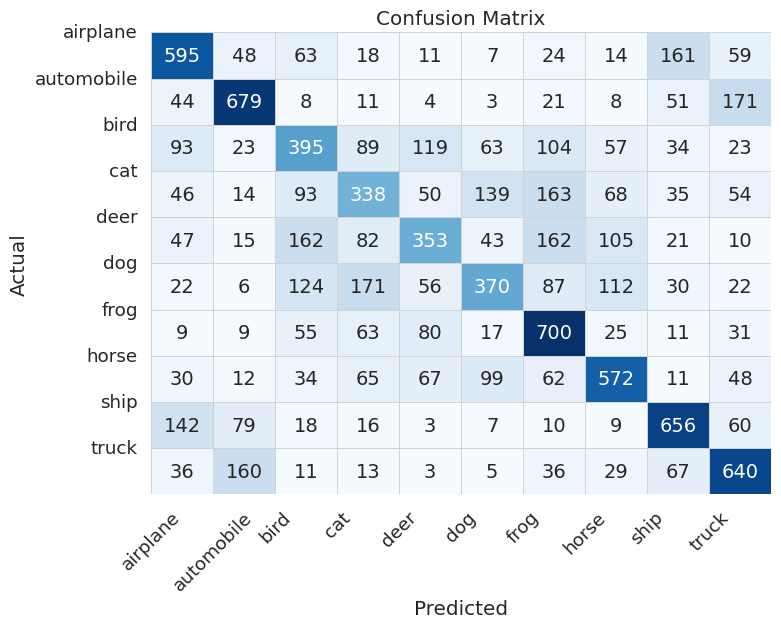

In [17]:
# Call the plot_confusion_matrix function
plot_confusion_matrix(preds, actuals, classes)